# Lithology Prediction

### Raw Data Exploration

* Show head (6 rows) of raw data
* Color map of lithology over longitude and latitude
* Histogram of lithology
* Missing part visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import warnings

% matplotlib inline

dfdata = pd.read_csv("data/train_clean.csv")
# sort dfdata based on longitude
dfdata = dfdata.sort_values("longitude")
dfdata.head()

,longitude,latitude,lithology,bathymetry,nitrate,oxygen,phosphate,productivity,salinity,silicate,temperature
0,-180,75,4,-231.0,NaN,8.552258,NaN,310.199677,31.165499,NaN,-0.878415
5962,-180,38,4,-5425.0,NaN,5.702333,NaN,427.678925,34.342628,NaN,15.691460
5757,-180,39,4,-5335.0,NaN,5.829761,NaN,497.673096,34.254448,NaN,14.695810
32077,-180,-55,4,-5287.0,NaN,6.456027,NaN,335.052032,34.125984,NaN,6.751073
5562,-180,40,4,-5241.0,NaN,5.968406,NaN,584.339844,34.158997,NaN,13.663589


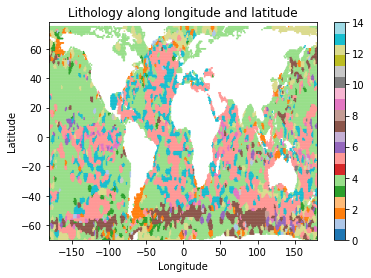

In [2]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values
y = dfdata["lithology"].values

# plot lithology vesus longitude and latitude
def draw_global(lon, lat, y, title, cmap="tab20", vmin=0, vmax=14):
    sc = pl.scatter(lon, lat, s=0.5, c=y, cmap=cmap, vmin=vmin, vmax=vmax)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
draw_global(lon, lat, y, "Lithology along longitude and latitude")

### Imbalanced Multiclass Classification
As we can see from the histogram of target lithology, the class distribution is not uniform. Some classes have large amount of samples whereas some classes have less samples. This enables model to cost less to predict those rare classes wrong. To fix this problem, we need to re-weight classes to obtain balanced classes.

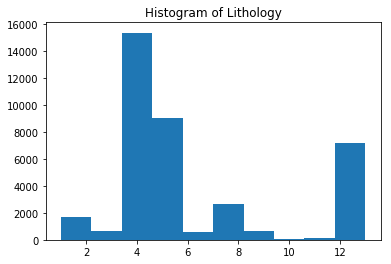

In [3]:
def draw_hist(y, title):
    # plot the histogram of lithology
    pl.hist(y)
    pl.title(title)
    pl.show()

draw_hist(y, "Histogram of Lithology")

### Keras - Neural Network Classification

We will deploy keras - a neural network library which is capable for running on top of Tensorflow.

In [4]:
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential, Model
from keras.callbacks import History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight
warnings.simplefilter("ignore")

Using Theano backend.


### Data preprocessing
* Normalize features X
* Onehot multiclass target Y

In [5]:
# obtain list of feature names
training_data = dfdata.copy()
target = "lithology"
features = list(training_data.columns)
features.remove(target)
features.remove("longitude")
features.remove("latitude")

# impute missing with mean
fill_dict = {}
for col in training_data:
    fill_dict[col] = np.mean(training_data[col])
training_data = training_data.fillna(value=fill_dict)

# extract X and Y
X = training_data[features].astype(float)
Y = training_data[target]

# standardize X
scaler = StandardScaler()
X = scaler.fit_transform(X)

# onehot target Y -> convert integers to dummy variables
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
dummy_Y = np_utils.to_categorical(Y)

# class reweighting for imbalanced class
weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

### Construct neural network
The neural network has the following structure:
- Input layer
- Hidden layer 1: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 2: consists of 64 nerons
- Dropout layer : drop out 20% of nerons to avoid overfitting
- Hidden layer 3: consists of 32 nerons
- Output layer

In [6]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)

# parameters for hidden layers
activation = "relu"
initializer = "random_uniform"
dropout_ratio = 0.1
numclass = dummy_Y.shape[1]
N, d = X.shape

# construct layers
inputs = Input(shape=(d,))
layer = Dense(64, activation=activation, kernel_initializer=initializer)(inputs)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(64, activation=activation, kernel_initializer=initializer)(layer)
layer = Dropout(dropout_ratio)(layer)
layer = Dense(32, activation=activation, kernel_initializer=initializer)(layer)
prediction = Dense(numclass, activation="softmax")(layer)

# create model
model = Model(inputs=inputs, outputs=prediction)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 13)                429       
Total para

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.4751 - acc: 0.4635 - val_loss: 1.6752 - val_acc: 0.4650
Epoch 2/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3784 - acc: 0.5102 - val_loss: 1.6861 - val_acc: 0.4742
Epoch 3/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3479 - acc: 0.5197 - val_loss: 1.6715 - val_acc: 0.4801
Epoch 4/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.3258 - acc: 0.5249 - val_loss: 1.6557 - val_acc: 0.4749
Epoch 5/200
24351/24351 [==============================] - 2s 96us/step - loss: 1.3063 - acc: 0.5293 - val_loss: 1.6077 - val_acc: 0.4831
Epoch 6/200
24351/24351 [==============================] - 2s 96us/step - loss: 1.2904 - acc: 0.5314 - val_loss: 1.6074 - val_acc: 0.4706
Epoch 7/200
24351/24351 [==============================] - 2s 96us/step - loss: 1.2805 - acc: 0.5371 - val_loss: 1.6486 - v

24351/24351 [==============================] - 2s 98us/step - loss: 1.0858 - acc: 0.5969 - val_loss: 1.9749 - val_acc: 0.4619
Epoch 60/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0797 - acc: 0.5958 - val_loss: 1.9017 - val_acc: 0.4744
Epoch 61/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0802 - acc: 0.5954 - val_loss: 1.9607 - val_acc: 0.4545
Epoch 62/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0773 - acc: 0.5963 - val_loss: 1.9401 - val_acc: 0.4734
Epoch 63/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0755 - acc: 0.5968 - val_loss: 1.9359 - val_acc: 0.4671
Epoch 64/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0724 - acc: 0.5990 - val_loss: 2.0615 - val_acc: 0.4622
Epoch 65/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0767 - acc: 0.5971 - val_loss: 1.9916 - val_acc: 0.4396
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0298 - acc: 0.6103 - val_loss: 2.0828 - val_acc: 0.4358
Epoch 119/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0312 - acc: 0.6152 - val_loss: 2.1570 - val_acc: 0.4162
Epoch 120/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0259 - acc: 0.6142 - val_loss: 2.1206 - val_acc: 0.4346
Epoch 121/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0238 - acc: 0.6126 - val_loss: 2.1437 - val_acc: 0.4414
Epoch 122/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0335 - acc: 0.6111 - val_loss: 2.1023 - val_acc: 0.4284
Epoch 123/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0278 - acc: 0.6146 - val_loss: 2.1037 - val_acc: 0.4274
Epoch 124/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0273 - acc: 0.6155 - val_loss: 2.0806 - val_acc: 0.4394
Epoch 125/200
24351/

24351/24351 [==============================] - 2s 96us/step - loss: 1.0022 - acc: 0.6212 - val_loss: 2.1864 - val_acc: 0.4359
Epoch 177/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0010 - acc: 0.6219 - val_loss: 2.1325 - val_acc: 0.4335
Epoch 178/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0022 - acc: 0.6232 - val_loss: 2.1917 - val_acc: 0.4207
Epoch 179/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0030 - acc: 0.6235 - val_loss: 2.1852 - val_acc: 0.4331
Epoch 180/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9960 - acc: 0.6260 - val_loss: 2.2531 - val_acc: 0.4292
Epoch 181/200
24351/24351 [==============================] - 2s 98us/step - loss: 1.0053 - acc: 0.6245 - val_loss: 2.2055 - val_acc: 0.4328
Epoch 182/200
24351/24351 [==============================] - 2s 97us/step - loss: 0.9936 - acc: 0.6282 - val_loss: 2.2135 - val_acc: 0.4377
Epoch 183/200
24351/24351 [=======

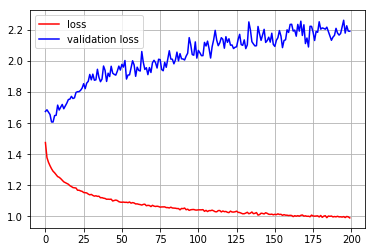

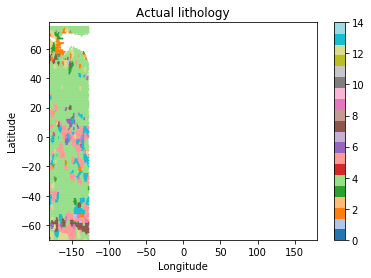

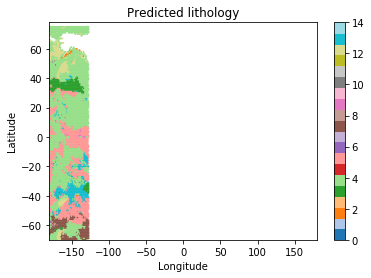

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.1335 - acc: 0.6095 - val_loss: 1.9202 - val_acc: 0.4859
Epoch 2/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0880 - acc: 0.6173 - val_loss: 2.0079 - val_acc: 0.4691
Epoch 3/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0677 - acc: 0.6217 - val_loss: 1.9778 - val_acc: 0.4694
Epoch 4/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0695 - acc: 0.6220 - val_loss: 1.9830 - val_acc: 0.4732
Epoch 5/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0562 - acc: 0.6227 - val_loss: 1.9767 - val_acc: 0.4671
Epoch 6/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0525 - acc: 0.6247 - val_loss: 2.0418 - val_acc: 0.4665
Epoch 7/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0452 - acc: 0.6294 - val_loss: 1.9513 - v

24351/24351 [==============================] - 2s 97us/step - loss: 0.9719 - acc: 0.6462 - val_loss: 2.1132 - val_acc: 0.4542
Epoch 60/200
24351/24351 [==============================] - 2s 97us/step - loss: 0.9707 - acc: 0.6473 - val_loss: 2.1529 - val_acc: 0.4550
Epoch 61/200
24351/24351 [==============================] - 2s 97us/step - loss: 0.9715 - acc: 0.6426 - val_loss: 2.1091 - val_acc: 0.4668
Epoch 62/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9716 - acc: 0.6418 - val_loss: 2.0710 - val_acc: 0.4621
Epoch 63/200
24351/24351 [==============================] - 2s 97us/step - loss: 0.9763 - acc: 0.6449 - val_loss: 2.0807 - val_acc: 0.4584
Epoch 64/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9681 - acc: 0.6474 - val_loss: 2.1347 - val_acc: 0.4506
Epoch 65/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9703 - acc: 0.6470 - val_loss: 2.0783 - val_acc: 0.4553
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9421 - acc: 0.6547 - val_loss: 2.1588 - val_acc: 0.4474
Epoch 119/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9491 - acc: 0.6556 - val_loss: 2.1948 - val_acc: 0.4323
Epoch 120/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9408 - acc: 0.6560 - val_loss: 2.1311 - val_acc: 0.4514
Epoch 121/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9475 - acc: 0.6516 - val_loss: 2.1601 - val_acc: 0.4504
Epoch 122/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9431 - acc: 0.6552 - val_loss: 2.1597 - val_acc: 0.4354
Epoch 123/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9420 - acc: 0.6582 - val_loss: 2.1753 - val_acc: 0.4530
Epoch 124/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9453 - acc: 0.6541 - val_loss: 2.1145 - val_acc: 0.4550
Epoch 125/200
24351/

24351/24351 [==============================] - 2s 95us/step - loss: 0.9333 - acc: 0.6579 - val_loss: 2.1606 - val_acc: 0.4671
Epoch 177/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9327 - acc: 0.6596 - val_loss: 2.2088 - val_acc: 0.4540
Epoch 178/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9302 - acc: 0.6566 - val_loss: 2.2130 - val_acc: 0.4448
Epoch 179/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9356 - acc: 0.6550 - val_loss: 2.1754 - val_acc: 0.4555
Epoch 180/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9271 - acc: 0.6612 - val_loss: 2.2188 - val_acc: 0.4573
Epoch 181/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9294 - acc: 0.6586 - val_loss: 2.1943 - val_acc: 0.4642
Epoch 182/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9272 - acc: 0.6601 - val_loss: 2.2006 - val_acc: 0.4611
Epoch 183/200
24351/24351 [=======

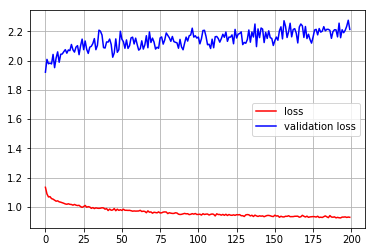

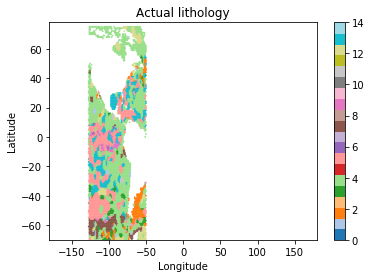

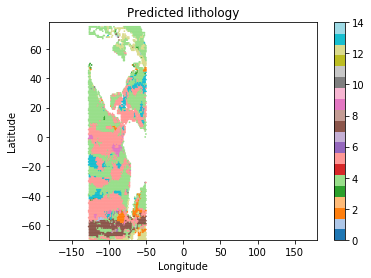

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 95us/step - loss: 1.1131 - acc: 0.6110 - val_loss: 2.0097 - val_acc: 0.4517
Epoch 2/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0533 - acc: 0.6250 - val_loss: 2.0806 - val_acc: 0.4506
Epoch 3/200
24351/24351 [==============================] - 2s 95us/step - loss: 1.0355 - acc: 0.6300 - val_loss: 2.0988 - val_acc: 0.4540
Epoch 4/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0316 - acc: 0.6305 - val_loss: 2.0590 - val_acc: 0.4566
Epoch 5/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0268 - acc: 0.6315 - val_loss: 2.0082 - val_acc: 0.4555
Epoch 6/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0092 - acc: 0.6343 - val_loss: 2.0578 - val_acc: 0.4476
Epoch 7/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0117 - acc: 0.6348 - val_loss: 2.1156 - v

24351/24351 [==============================] - 2s 94us/step - loss: 0.9500 - acc: 0.6509 - val_loss: 2.1973 - val_acc: 0.4524
Epoch 60/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9463 - acc: 0.6575 - val_loss: 2.1864 - val_acc: 0.4675
Epoch 61/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9432 - acc: 0.6588 - val_loss: 2.2421 - val_acc: 0.4511
Epoch 62/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9480 - acc: 0.6530 - val_loss: 2.2261 - val_acc: 0.4530
Epoch 63/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9387 - acc: 0.6594 - val_loss: 2.1675 - val_acc: 0.4716
Epoch 64/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9429 - acc: 0.6540 - val_loss: 2.1860 - val_acc: 0.4566
Epoch 65/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9508 - acc: 0.6559 - val_loss: 2.2169 - val_acc: 0.4529
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9310 - acc: 0.6587 - val_loss: 2.1882 - val_acc: 0.4545
Epoch 119/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9229 - acc: 0.6624 - val_loss: 2.1875 - val_acc: 0.4634
Epoch 120/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9289 - acc: 0.6626 - val_loss: 2.2211 - val_acc: 0.4580
Epoch 121/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9264 - acc: 0.6610 - val_loss: 2.1948 - val_acc: 0.4369
Epoch 122/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9328 - acc: 0.6572 - val_loss: 2.2077 - val_acc: 0.4458
Epoch 123/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9309 - acc: 0.6646 - val_loss: 2.2012 - val_acc: 0.4486
Epoch 124/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9196 - acc: 0.6658 - val_loss: 2.1727 - val_acc: 0.4602
Epoch 125/200
24351/

24351/24351 [==============================] - 2s 94us/step - loss: 0.9135 - acc: 0.6677 - val_loss: 2.2791 - val_acc: 0.4471
Epoch 177/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9224 - acc: 0.6613 - val_loss: 2.1990 - val_acc: 0.4598
Epoch 178/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9184 - acc: 0.6654 - val_loss: 2.2078 - val_acc: 0.4709
Epoch 179/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9237 - acc: 0.6628 - val_loss: 2.2873 - val_acc: 0.4543
Epoch 180/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9105 - acc: 0.6635 - val_loss: 2.1616 - val_acc: 0.4606
Epoch 181/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9212 - acc: 0.6651 - val_loss: 2.1897 - val_acc: 0.4527
Epoch 182/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9127 - acc: 0.6652 - val_loss: 2.2305 - val_acc: 0.4532
Epoch 183/200
24351/24351 [=======

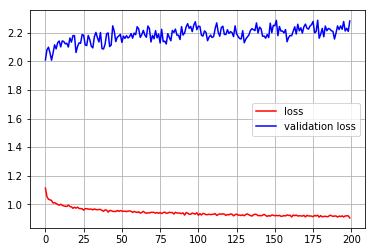

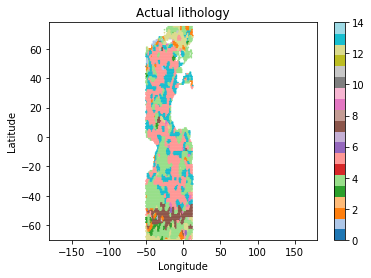

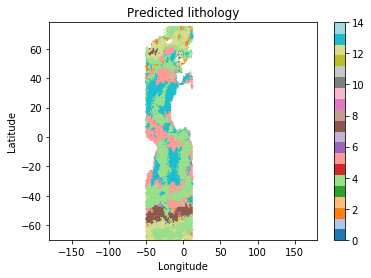

Train on 24351 samples, validate on 6088 samples
Epoch 1/200
24351/24351 [==============================] - 2s 97us/step - loss: 1.0585 - acc: 0.6185 - val_loss: 2.0854 - val_acc: 0.4581
Epoch 2/200
24351/24351 [==============================] - 2s 94us/step - loss: 1.0248 - acc: 0.6296 - val_loss: 2.1147 - val_acc: 0.4642
Epoch 3/200
24351/24351 [==============================] - 2s 95us/step - loss: 1.0169 - acc: 0.6296 - val_loss: 2.1189 - val_acc: 0.4540
Epoch 4/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9983 - acc: 0.6331 - val_loss: 2.1242 - val_acc: 0.4604
Epoch 5/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9938 - acc: 0.6342 - val_loss: 2.1553 - val_acc: 0.4675
Epoch 6/200
24351/24351 [==============================] - 2s 95us/step - loss: 0.9914 - acc: 0.6376 - val_loss: 2.1310 - val_acc: 0.4602
Epoch 7/200
24351/24351 [==============================] - 2s 96us/step - loss: 0.9890 - acc: 0.6376 - val_loss: 2.1692 - v

24351/24351 [==============================] - 2s 94us/step - loss: 0.9297 - acc: 0.6606 - val_loss: 2.2229 - val_acc: 0.4724
Epoch 60/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9244 - acc: 0.6617 - val_loss: 2.2002 - val_acc: 0.4719
Epoch 61/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9272 - acc: 0.6622 - val_loss: 2.2506 - val_acc: 0.4714
Epoch 62/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9321 - acc: 0.6622 - val_loss: 2.1987 - val_acc: 0.4713
Epoch 63/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9265 - acc: 0.6598 - val_loss: 2.2538 - val_acc: 0.4662
Epoch 64/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9215 - acc: 0.6630 - val_loss: 2.1830 - val_acc: 0.4645
Epoch 65/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9237 - acc: 0.6623 - val_loss: 2.1469 - val_acc: 0.4652
Epoch 66/200
24351/24351 [==============

Epoch 118/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9101 - acc: 0.6665 - val_loss: 2.2838 - val_acc: 0.4634
Epoch 119/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9010 - acc: 0.6697 - val_loss: 2.2585 - val_acc: 0.4497
Epoch 120/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9062 - acc: 0.6700 - val_loss: 2.2615 - val_acc: 0.4520
Epoch 121/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9198 - acc: 0.6636 - val_loss: 2.2480 - val_acc: 0.4506
Epoch 122/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9083 - acc: 0.6670 - val_loss: 2.2642 - val_acc: 0.4586
Epoch 123/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9101 - acc: 0.6665 - val_loss: 2.2342 - val_acc: 0.4622
Epoch 124/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9195 - acc: 0.6663 - val_loss: 2.1766 - val_acc: 0.4680
Epoch 125/200
24351/

24351/24351 [==============================] - 2s 93us/step - loss: 0.9112 - acc: 0.6662 - val_loss: 2.2970 - val_acc: 0.4553
Epoch 177/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9062 - acc: 0.6667 - val_loss: 2.2937 - val_acc: 0.4665
Epoch 178/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.8939 - acc: 0.6732 - val_loss: 2.3033 - val_acc: 0.4566
Epoch 179/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.8975 - acc: 0.6701 - val_loss: 2.2735 - val_acc: 0.4667
Epoch 180/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9065 - acc: 0.6734 - val_loss: 2.2701 - val_acc: 0.4601
Epoch 181/200
24351/24351 [==============================] - 2s 94us/step - loss: 0.9064 - acc: 0.6711 - val_loss: 2.3067 - val_acc: 0.4465
Epoch 182/200
24351/24351 [==============================] - 2s 93us/step - loss: 0.9096 - acc: 0.6672 - val_loss: 2.2713 - val_acc: 0.4694
Epoch 183/200
24351/24351 [=======

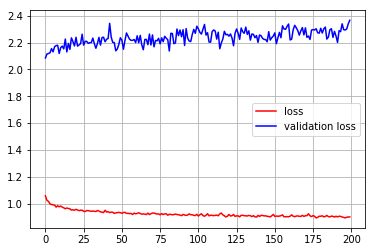

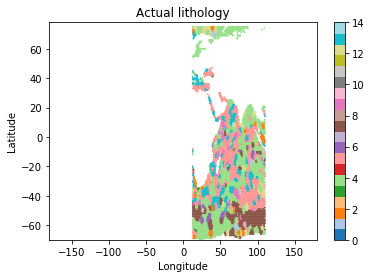

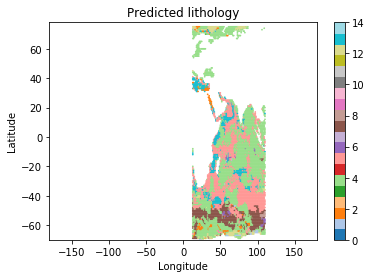

Train on 24352 samples, validate on 6088 samples
Epoch 1/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9580 - acc: 0.6615 - val_loss: 1.6129 - val_acc: 0.5008
Epoch 2/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9308 - acc: 0.6583 - val_loss: 1.5618 - val_acc: 0.4989
Epoch 3/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9290 - acc: 0.6635 - val_loss: 1.5590 - val_acc: 0.5105
Epoch 4/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.9191 - acc: 0.6645 - val_loss: 1.5914 - val_acc: 0.4918
Epoch 5/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9111 - acc: 0.6668 - val_loss: 1.5797 - val_acc: 0.5018
Epoch 6/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9150 - acc: 0.6645 - val_loss: 1.5760 - val_acc: 0.4921
Epoch 7/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9136 - acc: 0.6624 - val_loss: 1.5737 - v

24352/24352 [==============================] - 2s 92us/step - loss: 0.8932 - acc: 0.6733 - val_loss: 1.6711 - val_acc: 0.4775
Epoch 60/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8920 - acc: 0.6710 - val_loss: 1.7143 - val_acc: 0.4676
Epoch 61/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8904 - acc: 0.6720 - val_loss: 1.6725 - val_acc: 0.4660
Epoch 62/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8837 - acc: 0.6756 - val_loss: 1.7099 - val_acc: 0.4780
Epoch 63/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8859 - acc: 0.6749 - val_loss: 1.7060 - val_acc: 0.4538
Epoch 64/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8933 - acc: 0.6736 - val_loss: 1.7438 - val_acc: 0.4667
Epoch 65/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.9011 - acc: 0.6718 - val_loss: 1.7597 - val_acc: 0.4512
Epoch 66/200
24352/24352 [==============

Epoch 118/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8773 - acc: 0.6733 - val_loss: 1.6925 - val_acc: 0.4759
Epoch 119/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8706 - acc: 0.6765 - val_loss: 1.8221 - val_acc: 0.4397
Epoch 120/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8864 - acc: 0.6710 - val_loss: 1.7665 - val_acc: 0.4548
Epoch 121/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8799 - acc: 0.6774 - val_loss: 1.7597 - val_acc: 0.4479
Epoch 122/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8920 - acc: 0.6739 - val_loss: 1.8249 - val_acc: 0.4343
Epoch 123/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8739 - acc: 0.6768 - val_loss: 1.8670 - val_acc: 0.4400
Epoch 124/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8823 - acc: 0.6772 - val_loss: 1.8257 - val_acc: 0.4205
Epoch 125/200
24352/

24352/24352 [==============================] - 2s 92us/step - loss: 0.8787 - acc: 0.6789 - val_loss: 1.8025 - val_acc: 0.4345
Epoch 177/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8760 - acc: 0.6758 - val_loss: 1.9238 - val_acc: 0.4304
Epoch 178/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8809 - acc: 0.6777 - val_loss: 1.8571 - val_acc: 0.4318
Epoch 179/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8837 - acc: 0.6741 - val_loss: 1.8995 - val_acc: 0.4317
Epoch 180/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8814 - acc: 0.6750 - val_loss: 1.8641 - val_acc: 0.4428
Epoch 181/200
24352/24352 [==============================] - 2s 93us/step - loss: 0.8759 - acc: 0.6775 - val_loss: 1.8222 - val_acc: 0.4422
Epoch 182/200
24352/24352 [==============================] - 2s 92us/step - loss: 0.8702 - acc: 0.6799 - val_loss: 1.8512 - val_acc: 0.4469
Epoch 183/200
24352/24352 [=======

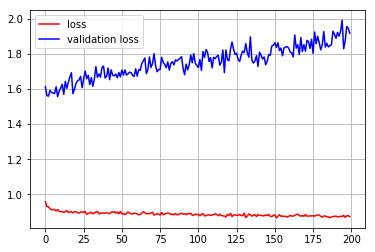

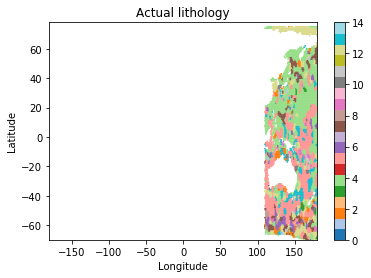

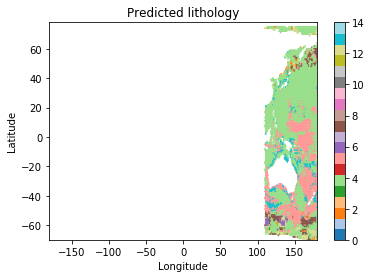

In [7]:
# parameters for training
epochs = 200
batch_size = 5
verbose = True

# use 5 fold cross validation without shuffle
kfold = KFold(n_splits=5, random_state=seed)
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

# training
prediction = np.zeros((N, numclass))
for train_ind, test_ind in kfold.split(X):
    train_X, train_Y = X[train_ind], dummy_Y[train_ind]
    # record loss in training and validation
    history = History()
    model.fit(train_X, train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose, class_weight=weight,
              validation_split=0.2, shuffle=True, callbacks=[history])
    # plot loss versus epochs
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    pl.plot(history.epoch, loss, "r-", label="loss")
    pl.plot(history.epoch, val_loss, "b-", label="validation loss")
    pl.grid()
    pl.legend()
    pl.show()
    # predict and draw scatterplot for prediction set
    mu = model.predict(X[test_ind])
    prediction[test_ind, :] = mu
    mean = np.argmax(mu, axis=1)
    draw_global(lon[test_ind], lat[test_ind], Y[test_ind] + 1, "Actual lithology")
    draw_global(lon[test_ind], lat[test_ind], mean + 1, "Predicted lithology")

### Validate

Accuracy = 0.45927619648348184


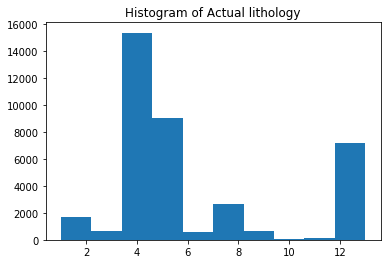

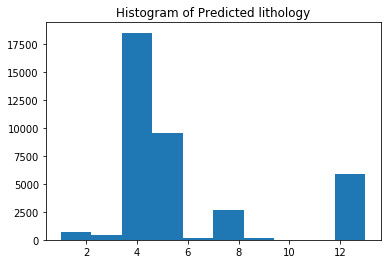

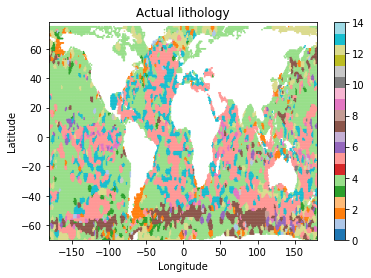

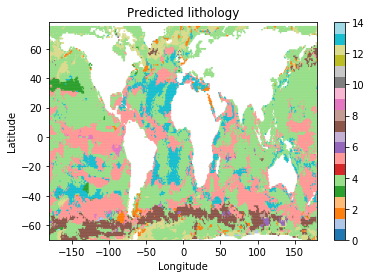

In [8]:
lon = dfdata["longitude"].values
lat = dfdata["latitude"].values

mean = np.argmax(prediction, axis=1)
print("Accuracy = {}".format(accuracy_score(Y, mean)))
draw_hist(Y + 1, "Histogram of Actual lithology")
draw_hist(mean + 1, "Histogram of Predicted lithology")
draw_global(lon, lat, Y + 1, "Actual lithology")
draw_global(lon, lat, mean + 1, "Predicted lithology")

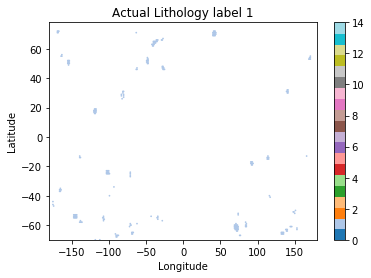

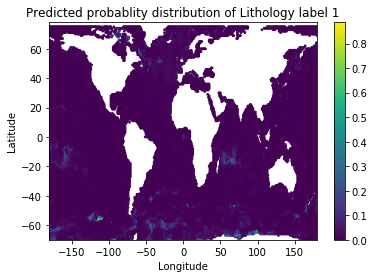

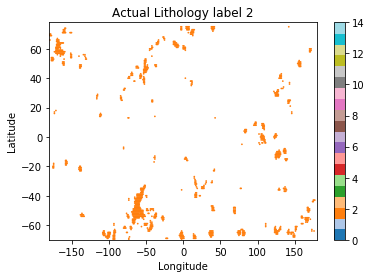

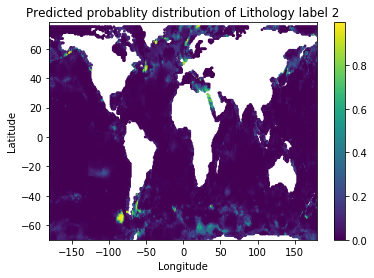

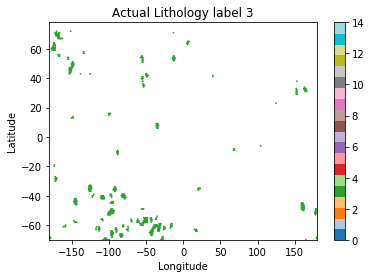

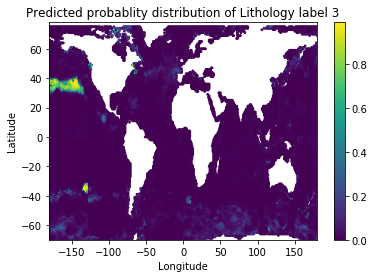

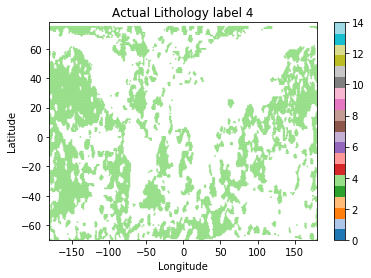

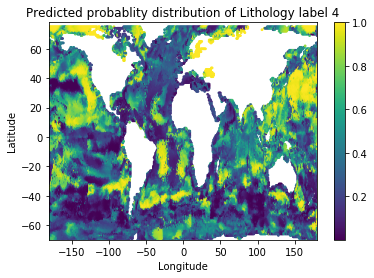

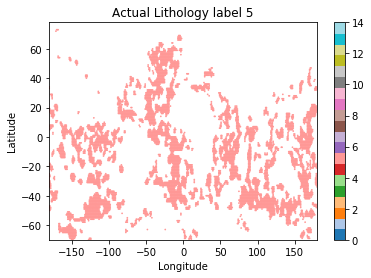

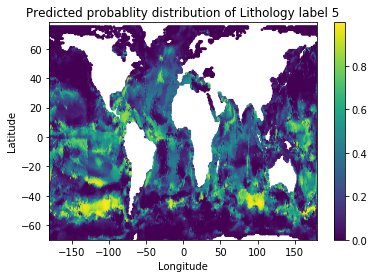

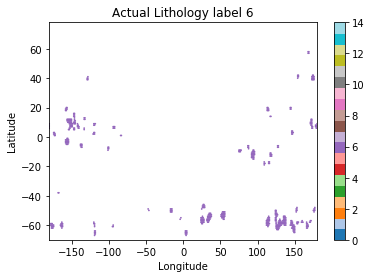

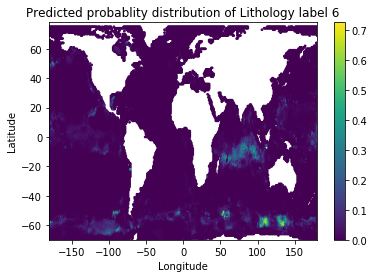

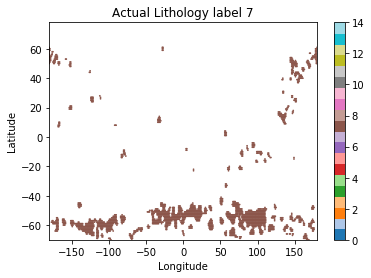

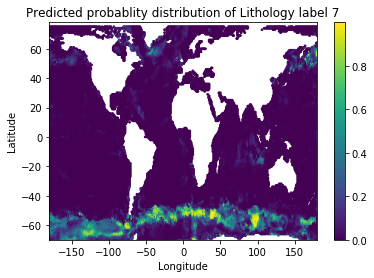

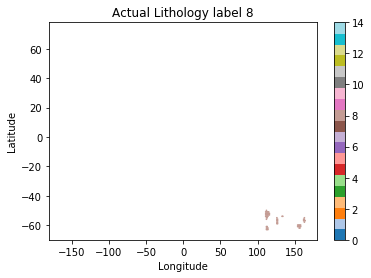

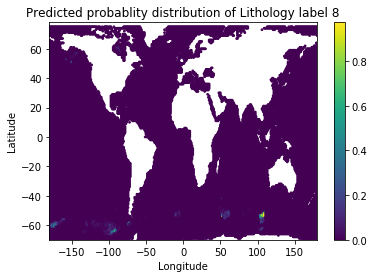

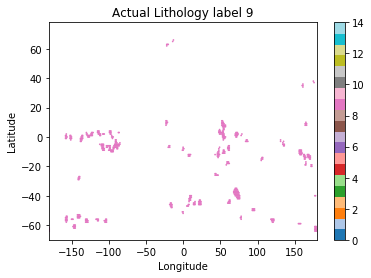

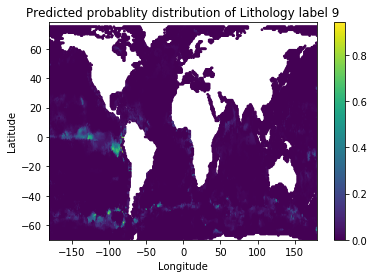

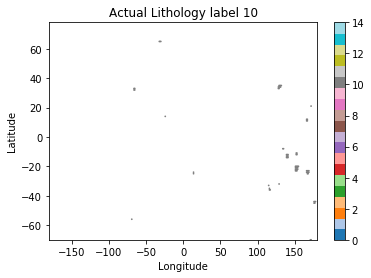

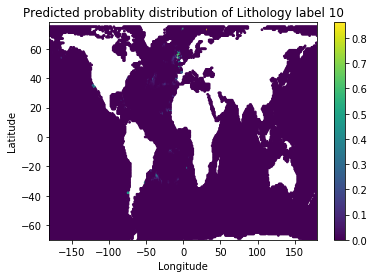

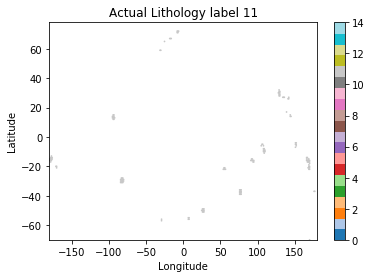

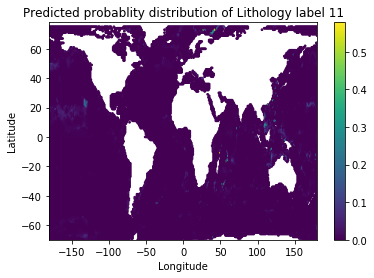

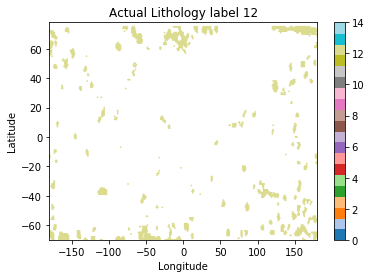

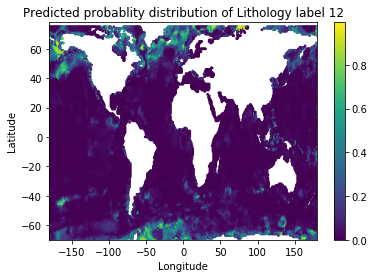

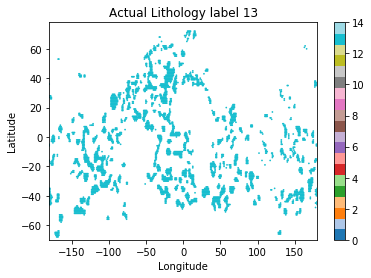

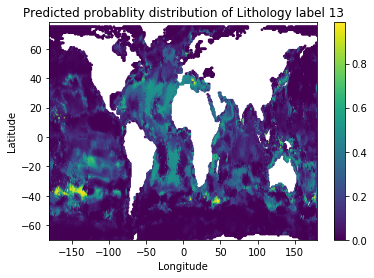

In [9]:
def draw_prob(lon, lat, p, title, size=3):
    sc = pl.scatter(lon, lat, s=size, c=p)
    pl.title(title)
    pl.xlim([-180, 180])
    pl.ylim([-70, 78])
    pl.xlabel("Longitude")
    pl.ylabel("Latitude")
    pl.colorbar(sc)
    pl.show()
    pl.close()
    
for i in range(13):
    common_part = "Lithology label {}".format(i + 1)
    title_p = "Predicted probablity distribution of {}".format(common_part)
    title_y = "Actual {}".format(common_part)
    # find Y_ts whose label is i + 1 and plot
    index = Y == i
    thisY = Y[Y == i] + 1
    draw_global(lon[index], lat[index], y=thisY, title=title_y)
    # plot prob distribution
    draw_prob(lon, lat, p = prediction[:,i], title=title_p)